# Exploring the beautiful city of Pune


## Introduction

The aim of the project is to identify venues in Pune, India based on their rating and average prices. In this notebook, we will identify various venues in the city of Pune, India, using Foursquare API and Zomato API, to help visitors select the restaurants that suit them the best.

 Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

 Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

Company can make recommendation app or if they want to open a restaurant or cafe, they can definitely see which neiborhood to targe and decide the price range to start with. 

## Data Collection from APIs 



To begin with, we will take a look at Pune on the Map using the folium library.

We will also fetch the data from two different APIs.

### Foursquare API
We begin by fetching a total of all venues in Pune upto a range of 4 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.
Foursquare API will give us following information :
    - Name of venue
    - Category of venue
    - Latitude and Logitude

### Zomato API
The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

Zomato API will provide us with following information :
    - Name of venue
    - Latitude and Logitude
    - Average cost for two
    - Price range
    - User ratings
    - Address

The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

#### import packages

In [5]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import geocoder

import urllib
import folium
from geopy.geocoders import Nominatim
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests


#### Get latitude and longitude of each postal code

In [11]:
PUNE_LATITUDE = 18.5204
PUNE_LONGITUDE = 73.8567
print('The geograpical coordinates of Pune are {}, {}.'.format(PUNE_LATITUDE, PUNE_LONGITUDE))

The geograpical coordinates of Pune are 18.5204, 73.8567.


In [15]:
import folium

pune_map = folium.Map(location = [PUNE_LATITUDE, PUNE_LONGITUDE], zoom_start = 13)
folium.Marker([PUNE_LATITUDE, PUNE_LONGITUDE]).add_to(pune_map)
pune_map

In [16]:
CLIENT_ID = 'BB11TZDQ4VWBFK2T3XHNG10RHDPNA0MP2I23TSFUTC4EAVL0' # your Foursquare ID
CLIENT_SECRET = 'TDKNRQYABO31FIU00R1DLTVHHQ2YPPIZND4VV20S15LXDDBV' # your Foursquare Secret
RADIUS = 4000 # 4 Km
NO_OF_VENUES = 100
VERSION = '20203101' # Current date

In [17]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Foursquare API
We begin by fetching a total of all venues in Pune upto a range of 4 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.


In [19]:

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        PUNE_LATITUDE, 
                                                                        PUNE_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 4.0 Km
Total 100 venues fetched within a total radius of 4.0 Km
Total 9 venues fetched within a total radius of 4.0 Km

Total 209 venues fetched


In [20]:
foursquare_venues.head()

,name,categories,lat,lng
0,Sujata Mastani,Ice Cream Shop,18.511793,73.852145
1,Lal Mahal,Historic Site,18.518720,73.856556
2,Bhagat Tarachand,Indian Restaurant,18.514332,73.851317
3,Mad Over Donuts,Donut Shop,18.519335,73.845320
4,Raja Dinkar Kelkar museum,History Museum,18.510744,73.854389


### Zomato API
The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.


In [21]:
headers = {'user-key': '09453a2386e2618e0fefccd9a3ffd07a'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

### Data Cleaning 
The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [22]:
pune_map = folium.Map(location = [PUNE_LATITUDE, PUNE_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(pune_map)  

pune_map.save("Venues by Foursquare.html")
pune_map

In [23]:
pune_map = folium.Map(location = [PUNE_LATITUDE, PUNE_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(pune_map)  

pune_map.save("Venues by Zomato.html")
pune_map



#### To combine the two datasets, I'll have to check that the latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values upto 4 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.


In [24]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [25]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [26]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Sujata Mastani,Ice Cream Shop,18.5118,73.8521,Sujata Mastani,18.5117,73.8522,250,1,4.3,"Survey 1260, Nimbalkar Talim Chowk, Sadashiv P...",-0.0001,0.0001
1,Bhagat Tarachand,Indian Restaurant,18.5143,73.8513,R Bhagat Tarrachand,18.5145,73.8514,600,2,4.0,"Survey 709, 2nd Floor, City Jewel Mall, Laxmi ...",0.0002,0.0001
2,Mad Over Donuts,Donut Shop,18.5193,73.8453,Mad Over Donuts,18.5193,73.8453,400,1,4.1,"Near Sambhaji Park, JM Road, Pune",0.0000,0.0000
3,Raja Dinkar Kelkar museum,History Museum,18.5107,73.8544,Bapat Veg Uphar Gruh,18.5106,73.8543,400,1,3.6,"Shop 2 & 3, 1376 Shukrawar Peth, Near Kelkar M...",-0.0001,-0.0001
4,Krishna Juice Bar,Juice Bar,18.5236,73.8477,Shree Krishna Juice Bar,18.5235,73.8477,150,1,3.9,"Plot 1187/27, Bhagirathi Building, Near Federa...",-0.0001,0.0000
5,Café GoodLuck,Café,18.5174,73.8415,Cafe Goodluck,18.5173,73.8415,650,2,4.1,"759/75, Goodluck Chowk, Deccan Gymkhana, Pune",-0.0001,0.0000
6,Hotel Roopali,Indian Restaurant,18.5193,73.8413,Roopali Restaurant,18.5194,73.8414,500,2,4.0,"1227, Opposite British Library, FC Road, Pune",0.0001,0.0001
7,Tilak Hotel,Snack Place,18.5096,73.8469,Hotel Tilak,18.5096,73.8470,350,1,4.2,"1549, Indira Chambers, Opposite Maharashtra Ma...",0.0000,0.0001
8,Vaishali | वैशाली,South Indian Restaurant,18.5209,73.8413,Vaishali,18.5209,73.8411,500,2,4.4,"1218/1, FC Road, Pune",0.0000,-0.0002
9,Barbeque Nation,BBQ Joint,18.5162,73.8422,UBQ by Barbeque Nation,18.5163,73.8425,400,1,3.7,"3rd Floor, R Deccan Mall, Ghole Road, Deccan G...",0.0001,0.0003


In [27]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 133


In [32]:
#selected_venues.to_csv("data_foursquare_zomato_combined.csv", index = False)

In [3]:
selected_venues = pd.read_csv("data_foursquare_zomato_combined_utf.csv")

## Methodology 
This project aims at identifying the venues in Pune based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.
As a first step, we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information from the center of Pune, up to a distance of 4 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyze the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.


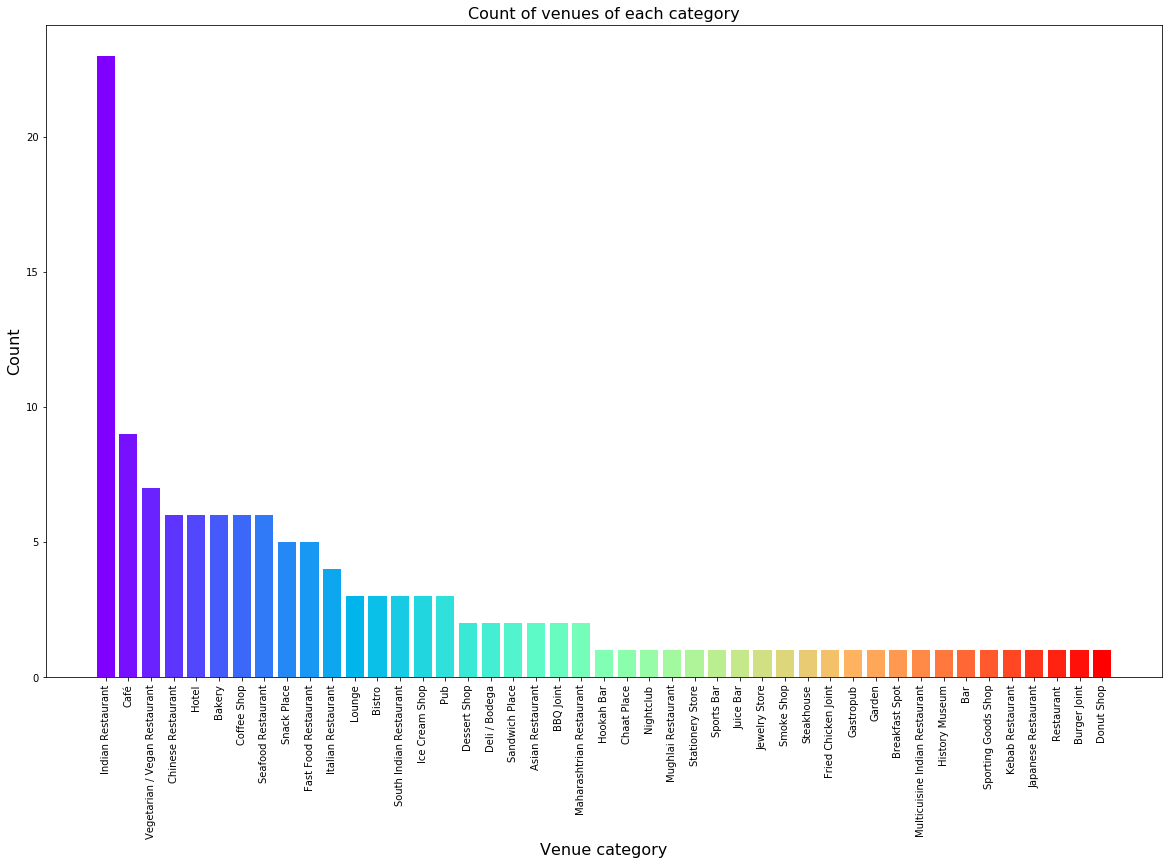

In [6]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)
plt.show()



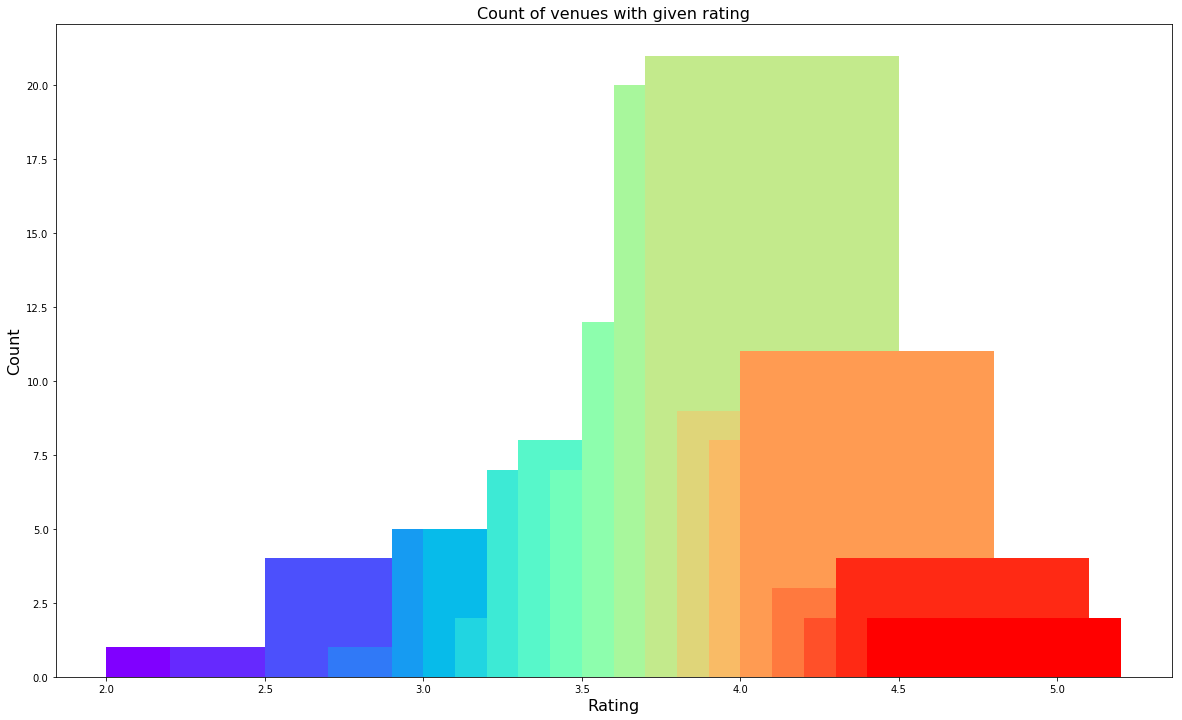

In [7]:

selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)
plt.show()



#### Let's categories the rating into 5 bins

In [8]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)



In [12]:

color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

pune_map = folium.Map(location = [PUNE_LATITUDE, PUNE_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(pune_map)  

pune_map.save("Venues Ratings.html")
pune_map


#### Let's see the ratings distribution in the data

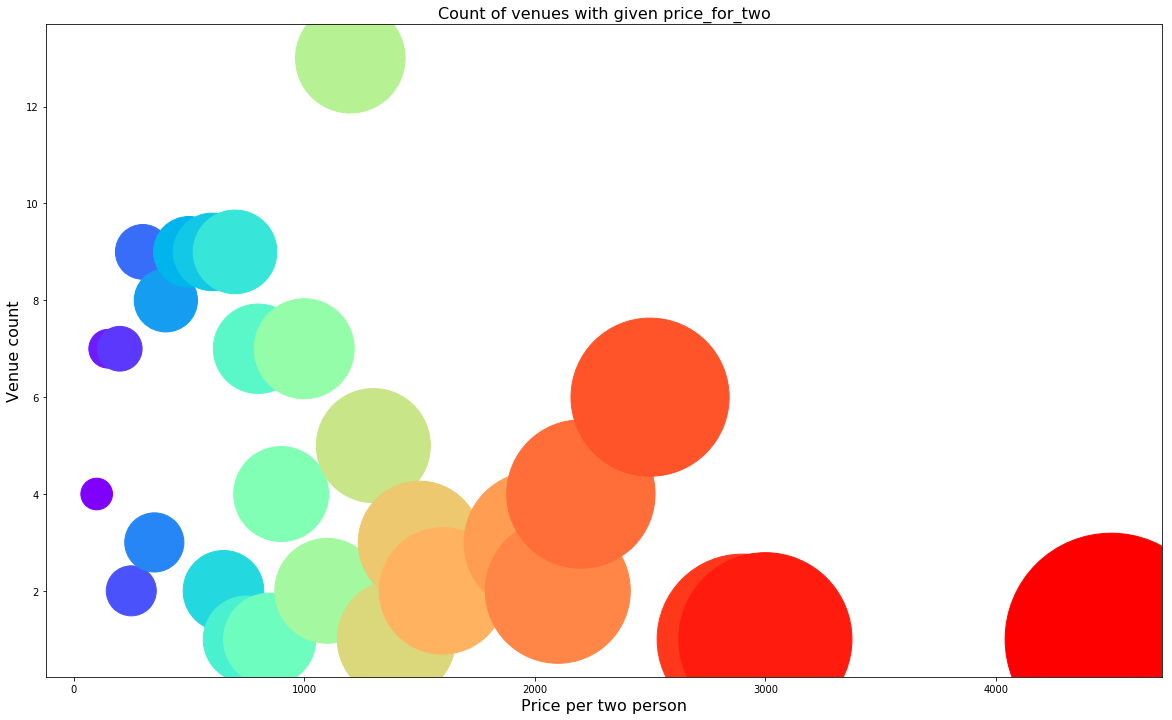

In [13]:
price_for_two = selected_venues['price_for_two'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(price_for_two.index, 
            price_for_two.values, 
            s = price_for_two.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(price_for_two.index))))
plt.xlabel("Price per two person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given price_for_two", fontsize = 16)
plt.show()


In [14]:
color_map = {'1': 'green', '2': 'darkgreen', '3': 'orange', '4': 'red'}

pune_map = folium.Map(location = [PUNE_LATITUDE, PUNE_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker([latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(pune_map)  

pune_map.save("Venues Prices.html")
pune_map


#### Let us form the clusters to make further claims

In [16]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 3

cols_to_drop = ['name', 'categories', 'lat', 'lng', 'venue', 'latitude', 'longitude',
        'address', 'lat_diff',
       'lng_diff', 'rating_bin']
clustering = selected_venues.drop(cols_to_drop, 1)

kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff,rating_bin
0,0,Sujata Mastani,Ice Cream Shop,18.5118,73.8521,Sujata Mastani,18.5117,73.8522,250,1,4.3,"Survey 1260, Nimbalkar Talim Chowk, Sadashiv P...",-0.0001,0.0001,Very good
1,0,Bhagat Tarachand,Indian Restaurant,18.5143,73.8513,R Bhagat Tarrachand,18.5145,73.8514,600,2,4.0,"Survey 709, 2nd Floor, City Jewel Mall, Laxmi ...",0.0002,0.0001,Good
2,0,Mad Over Donuts,Donut Shop,18.5193,73.8453,Mad Over Donuts,18.5193,73.8453,400,1,4.1,"Near Sambhaji Park, JM Road, Pune",0.0000,0.0000,Very good
3,0,Raja Dinkar Kelkar museum,History Museum,18.5107,73.8544,Bapat Veg Uphar Gruh,18.5106,73.8543,400,1,3.6,"Shop 2 & 3, 1376 Shukrawar Peth, Near Kelkar M...",-0.0001,-0.0001,Good
4,0,Krishna Juice Bar,Juice Bar,18.5236,73.8477,Shree Krishna Juice Bar,18.5235,73.8477,150,1,3.9,"Plot 1187/27, Bhagirathi Building, Near Federa...",-0.0001,0.0000,Good


In [17]:
pune_map = folium.Map(location = [PUNE_LATITUDE, PUNE_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red', 2: 'blue'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(pune_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(pune_map)

pune_map.save("Venues Clusters.html")
pune_map


In [18]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)


Cluster 0


,cluster_labels,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff,rating_bin
0,0,Sujata Mastani,Ice Cream Shop,18.5118,73.8521,Sujata Mastani,18.5117,73.8522,250,1,4.3,"Survey 1260, Nimbalkar Talim Chowk, Sadashiv P...",-0.0001,0.0001,Very good
1,0,Bhagat Tarachand,Indian Restaurant,18.5143,73.8513,R Bhagat Tarrachand,18.5145,73.8514,600,2,4.0,"Survey 709, 2nd Floor, City Jewel Mall, Laxmi ...",0.0002,0.0001,Good
2,0,Mad Over Donuts,Donut Shop,18.5193,73.8453,Mad Over Donuts,18.5193,73.8453,400,1,4.1,"Near Sambhaji Park, JM Road, Pune",0.0000,0.0000,Very good
3,0,Raja Dinkar Kelkar museum,History Museum,18.5107,73.8544,Bapat Veg Uphar Gruh,18.5106,73.8543,400,1,3.6,"Shop 2 & 3, 1376 Shukrawar Peth, Near Kelkar M...",-0.0001,-0.0001,Good
4,0,Krishna Juice Bar,Juice Bar,18.5236,73.8477,Shree Krishna Juice Bar,18.5235,73.8477,150,1,3.9,"Plot 1187/27, Bhagirathi Building, Near Federa...",-0.0001,0.0000,Good
5,0,Café GoodLuck,Café,18.5174,73.8415,Cafe Goodluck,18.5173,73.8415,650,2,4.1,"759/75, Goodluck Chowk, Deccan Gymkhana, Pune",-0.0001,0.0000,Very good
6,0,Hotel Roopali,Indian Restaurant,18.5193,73.8413,Roopali Restaurant,18.5194,73.8414,500,2,4.0,"1227, Opposite British Library, FC Road, Pune",0.0001,0.0001,Good
7,0,Tilak Hotel,Snack Place,18.5096,73.8469,Hotel Tilak,18.5096,73.8470,350,1,4.2,"1549, Indira Chambers, Opposite Maharashtra Ma...",0.0000,0.0001,Very good
8,0,Vaishali | ??????,South Indian Restaurant,18.5209,73.8413,Vaishali,18.5209,73.8411,500,2,4.4,"1218/1, FC Road, Pune",0.0000,-0.0002,Very good
9,0,Barbeque Nation,BBQ Joint,18.5162,73.8422,UBQ by Barbeque Nation,18.5163,73.8425,400,1,3.7,"3rd Floor, R Deccan Mall, Ghole Road, Deccan G...",0.0001,0.0003,Good


In [19]:
print("These venues for cluster 0 have mean price_for_two of {:.02f} and rating spread around {:.02f}".
      format(result['price_for_two'].mean(), result['rating'].astype(float).mean()))


These venues for cluster 0 have mean price_for_two of 407.86 and rating spread around 3.87


In [20]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff,rating_bin
0,1,Thousand Oaks / 1000 Oaks,Bar,18.5107,73.8800,1000 Oaks,18.5106,73.8799,2200,4,4.1,"2417, Near HDFC Bank, East Street, Pune",-0.0001,-0.0001,Very good
1,1,JW Marriott Hotel Pune,Hotel,18.5324,73.8298,Paasha - JW Marriott Pune,18.5322,73.8297,2500,4,4.7,"JW Marriott, Senapati Bapat Road, Pune",-0.0002,-0.0001,Very good
2,1,Sheraton Grand Pune,Hotel,18.5301,73.8714,Roof Top Bar - Sheraton Grand,18.5300,73.8713,2900,4,3.3,"Sheraton Grand, Raja Bahadur Mill Road, Bund G...",-0.0001,-0.0001,Good
3,1,Spice Kitchen,Asian Restaurant,18.5319,73.8296,Spice Kitchen - JW Marriott Pune,18.5318,73.8297,2200,4,4.4,"JW Marriott, Senapati Bapat Road, Pune",-0.0001,0.0001,Very good
4,1,Paasha,Lounge,18.5321,73.8296,Paasha - JW Marriott Pune,18.5322,73.8297,2500,4,4.7,"JW Marriott, Senapati Bapat Road, Pune",0.0001,0.0001,Very good
5,1,Pune Baking Company,Bakery,18.5320,73.8298,Spice Kitchen - JW Marriott Pune,18.5318,73.8297,2200,4,4.4,"JW Marriott, Senapati Bapat Road, Pune",-0.0002,-0.0001,Very good
6,1,Little Italy,Italian Restaurant,18.5348,73.8381,Little Italy,18.5349,73.8381,2100,4,4.4,"465, Ganeshkhind, Next To Pune Central Mall, O...",0.0001,0.0000,Very good
7,1,Alto Vino,Italian Restaurant,18.5320,73.8298,Alto Vino - JW Marriott Pune,18.5322,73.8297,3000,4,4.4,"JW Marriott, Senapati Bapat Road, Pune",0.0002,-0.0001,Very good
8,1,"Lobby Lounge, JW Marriott",Lounge,18.5319,73.8296,Spice Kitchen - JW Marriott Pune,18.5318,73.8297,2200,4,4.4,"JW Marriott, Senapati Bapat Road, Pune",-0.0001,0.0001,Very good
9,1,EVVIVA Sky Lounge,Lounge,18.5314,73.8767,Evviva Sky Lounge - Crowne Plaza Pune City Centre,18.5314,73.8767,2500,4,4.1,"CTS 37 & 37/1, 8th Floor, Crowne Plaza Pune Ci...",0.0000,0.0000,Very good


In [21]:
print("These venues for cluster 1 have mean price_for_two of {:.02f} and rating spread around {:.02f}".
      format(result['price_for_two'].mean(), result['rating'].astype(float).mean()))


These venues for cluster 1 have mean price_for_two of 2466.67 and rating spread around 4.19


In [22]:
result = selected_venues[selected_venues['cluster_labels'] == 2]
print("Cluster 2")
result.head(10).reset_index(drop = True)



Cluster 2


,cluster_labels,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff,rating_bin
0,2,Le Plaisir,Bistro,18.5142,73.8386,Le Plaisir,18.5143,73.8385,1000,3,4.7,"Survey 759/125, Rajkamal, Opposite Kelkar Eye ...",0.0001,-0.0001,Very good
1,2,J 1,Maharashtrian Restaurant,18.5242,73.8435,J1-????,18.5243,73.8437,900,2,4.1,"Survey 1202/5, Ghole Road, Near MJM Hospital, ...",0.0001,0.0002,Very good
2,2,Coconut Grove,Seafood Restaurant,18.5257,73.8670,Coconut Grove Resto-Bar,18.5255,73.8671,1200,3,4.0,"Survey 408/B, Akshaya Guestline, Ambedkar Bhav...",-0.0002,0.0001,Good
3,2,Mahesh Lunch Home,Seafood Restaurant,18.5206,73.8724,Mahesh Lunch Home,18.5207,73.8724,1500,3,4.0,"Shop 18, Ashoka Pavillion, Near Lal Deval, Amb...",0.0001,0.0000,Good
4,2,Shabree,Indian Restaurant,18.5246,73.8417,Shabree Restaurant,18.5245,73.8415,800,2,4.1,"Parichay Hotel, 1199/1A, FC Road, Pune",-0.0001,-0.0002,Very good
5,2,The Chocolate Room,Coffee Shop,18.5185,73.8416,The Chocolate Room,18.5186,73.8415,900,2,4.2,"1229, A Narhari, Near Sagar Arcade, Goodluck C...",0.0001,-0.0001,Very good
6,2,Hidden Place - The Crazy Frog,Pub,18.5365,73.8754,Hidden Place - BrewHaHa,18.5366,73.8754,1300,3,4.1,"33, 34 & 36, Ground Floor, Akshay Complex, Off...",0.0001,0.0000,Very good
7,2,Touché The Sizzler (The Place),Steakhouse,18.5186,73.8786,The Place - Touche The Sizzler,18.5185,73.8787,1000,3,4.0,"Shop 7, Clover Centre, Moledina Road, Camp Are...",-0.0001,0.0001,Good
8,2,Conrad Pune,Hotel,18.5350,73.8831,Pune Sugar Box - Conrad Pune,18.5349,73.8831,1000,3,4.3,"Conrad, Mangaldas Road, Bund Garden Road, Pune",-0.0001,0.0000,Very good
9,2,Nisarg (??????),Seafood Restaurant,18.5067,73.8320,Nisarg,18.5068,73.8321,1300,3,4.2,"6/1, Opposite Padale Palace, Nalstop, Erandwan...",0.0001,0.0001,Very good


In [23]:
print("These venues for cluster 2 have mean price_for_two of {:.02f} and rating spread around {:.02f}".
      format(result['price_for_two'].mean(), result['rating'].astype(float).mean()))



These venues for cluster 2 have mean price_for_two of 1121.11 and rating spread around 3.99


### Results and Discussion 
Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Pune, India.

After collecting data from the Foursquare and Zomato APIs, we got a list of 205 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 133.

We identified that from the total set of venues, majority of them were Cafes and Indian Restaurants. A visitor who loves Cafes/Indian Restaurants would surely benefit from coming to Pune.

While the complete range of ratings range from 1 to 5, the majority venues have ratings close to 4. This means that most restaurants provide good quality food which is liked by the people of the city, thus indicating the high rating. 
When we plot these venues on the map, we discover that there are clusters of venues around senapati bapat road, Koregaon park and FC road. These clusters also have very high ratings (more than 3).

When we take a look at the price values of each venue, we explore that many venues have prices which are in the range of Rs 1000 to Rs 2000 for two persons. However, the variation in prices is very large, given the complete range starts from Rs 100 and goes uptil Rs 4500. On plotting the venues based on their price range on the map, we discovered that venues located near Senapati Bapat road are relatively priced higher than other venues.

Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of 3.87. On the other hand, there are few venues which are high priced and have average rating of 4.19.

If you're looking for cheap places with relatively high rating, you should check JM road and FC road.
If you're looking for the best places, with the highest rating but might also carry a high price tag, you should visit Senapati Bapat road.
If you're looking to explore the city and have no specific criteria to decide upon the places you want to visit, you should try Koregaon park.
A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).


 ### Conclusion 
 The purpose of this project was to explore the places that a person visiting Pune could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are three major areas a person can visit: JM road & FC road, Senapati Bapat road and Koregaon park. Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.
